In [1]:
import os
import torch
import wandb

import pytorch_lightning as pl
import numpy as np
import geopandas as gpd
import rioxarray as xr
import xarray as xar

from pl_bolts.models.regression import LogisticRegression
from pytorch_lightning.loggers import WandbLogger
from datetime import datetime
from codecarbon import EmissionsTracker
from tqdm.notebook import tqdm
from argparse import ArgumentParser
from represent.datamodules.uc5_forest_biomass_datamodule import UC5ForestBiomassDataset, UC5ForestBiomassDataModule, TimeSeriesReductions
from represent.models.uc5_resnet import UC5ResNet
from represent.callbacks.delayed_unfreeze import DelayedUnfreeze
from represent.models.moco import DualMoco

from represent.transforms.augmentations import get_data_augmentation
from represent.tools.utils import seed_all
from represent.tools.plots import plot_img_grid

torch.backends.cudnn.benchmark = True
torch.set_default_dtype(torch.float32)

/home/lloyd/anaconda3/envs/epfl/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

def plot_regression(targets, preds):
    r2 = np.round(r2_score(targets, preds), 2)
    rmse = np.round(np.sqrt(mean_squared_error(targets, preds)), 2)
    
    plt.figure()
    plt.plot([0, 35], [0, 35], 'r--', linewidth=1)
    ax = sns.regplot(x=targets, y=preds)
    _=plt.title(f"H, RMSE={rmse:.3}, R2={r2:.2}")
    ax.set_xlabel("Target Height (m)")
    ax.set_ylabel("Predicted Height (m)")

In [3]:
S2_ONLY = False
PATCH_SIZE_PX = 12

input_ch = [13] if S2_ONLY else [2, 13]

config = dict(
    # DataModule Settings
    data_dir = "/data/lloyd/RepreSent/UC5",
    seed = 42,
    batch_size = 16,
    num_workers = 0,
    reduce_ts = "mean",
    patch_size_px = PATCH_SIZE_PX,
    training_set_fraction = 0.5,
    s2_level = "L1C",
    s2_only = S2_ONLY,
    
    # Trainer Settings
    gpus = 1,
    accelerator="gpu",
    strategy = None,
    
    # Model Parameters
    use_mlp = True,
    input_ch = input_ch,
    checkpoint = "represent/represent/weights/moco_resnet18.pth",
    
    # Optimizer Parameteres
    optimizer = "Adam",
    scheduler = "CosineAnnealingLR",
    momentum = 0.9,
    max_epochs = 80,
    learning_rate = 0.0007,
)

parser = ArgumentParser()
parser = pl.Trainer.add_argparse_args(parser)
parser = UC5ResNet.add_model_specific_args(parser)
parser = UC5ForestBiomassDataModule.add_model_specific_args(parser)

args, arg_strings = parser.parse_known_args([], None)
for key, value in config.items():
    setattr(args, key, value)

seed_all(config['seed'])

Global seed set to 42


In [4]:
ts = datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
run_name = f"UC5_ResNet_{ts}"
logger = WandbLogger(project="RepreSent_UC5", name=run_name, log_model=True, save_code=True)
# logger=None

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hughes-lloyd. Use `wandb login --relogin` to force relogin


In [5]:
s1_norm = lambda x: 20*np.log10(x/535)

uc5_datamodule = UC5ForestBiomassDataModule.from_argparse_args(args, s1_transform=s1_norm)

In [6]:
classifier = LogisticRegression(input_dim=2048, num_classes=1)
classifier = classifier.linear

if S2_ONLY:
    args.classification_head = torch.nn.Linear(512, 1)
else:
    args.classification_head = torch.nn.Linear(1024, 1)

model = UC5ResNet(**args.__dict__)

# Load Pretrained Weights

In [7]:
# Initialize both models
s2_bands = None if config['s2_level'] == 'L1C' else [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12]

if S2_ONLY:
    model.load_from_checkpoint(config['checkpoint'], filter_and_remap="s2_moco.encoder_q.", stream_id=0, input_ch_subset=s2_bands)
else:
    model.load_from_checkpoint(config['checkpoint'], filter_and_remap="s1_moco.encoder_q.", stream_id=0)
    model.load_from_checkpoint(config['checkpoint'], filter_and_remap="s2_moco.encoder_q.", stream_id=1, input_ch_subset=s2_bands)

# Fine-tune

In [8]:
checkpointer = pl.callbacks.ModelCheckpoint(
    dirpath=f'checkpoints/UC5ResNet/{run_name}',
    filename="{epoch}-{val_r2:.2f}",
    monitor="val_r2",
    mode="max",
    save_last=True,
)

# early_stopping_callback = pl.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=15)

unfreezer = DelayedUnfreeze(backbone_id="streams", unfreeze_at_epoch=10, train_frozen_bn=True, reset_lr=0.0001)

callbacks = [checkpointer, unfreezer]

# Done in callback
# for s in model.streams:
#     for p in s.parameters():
#         p.requires_grad = False

In [9]:
trainer = pl.Trainer.from_argparse_args(args, enable_checkpointing=True, 
                                        logger=logger, callbacks=callbacks, 
                                        auto_lr_find=False, log_every_n_steps=30)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [10]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

# tracker = EmissionsTracker()
# tracker.start()
try:
    run = trainer.fit(model, datamodule=uc5_datamodule)
finally:
    wandb.finish()
# emissions = tracker.stop()
# print(emissions)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | streams    | ModuleList | 22.9 M
1 | classifier | Linear     | 1.0 K 
------------------------------------------
20.2 K    Trainable params
22.9 M    Non-trainable params
22.9 M    Total params
91.630    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/lloyd/anaconda3/envs/epfl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
/home/lloyd/anaconda3/envs/epfl/lib/python3.8/site-packages/pytorch_lightning/train

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/lloyd/anaconda3/envs/epfl/lib/python3.8/site-packages/pytorch_lightning/callbacks/finetuning.py:210: UserWarning: The provided params to be frozen already exist within another group of this optimizer. Those parameters will be skipped.
HINT: Did you init your optimizer in `configure_optimizer` as such:
 <class 'torch.optim.adam.Adam'>(filter(lambda p: p.requires_grad, self.parameters()), ...) 
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,█▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_r2,▁▅▇▇▇▇██████████████████████████████████
train_rmse,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_loss,█▄▃▃▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_r2,▁▅▆▇▇▇▇██▇██████████████████████████████
val_rmse,█▅▃▃▃▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,79
train_loss,5.1542
train_r2,0.89469


# Tune Learning Rate

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/lloyd/anaconda3/envs/epfl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
/home/lloyd/anaconda3/envs/epfl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve 

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0007079457843841385
Restoring states from the checkpoint path at /home/lloyd/Documents/Experiments/RepreSent/.lr_find_36f51292-97c4-430b-90ed-b2c2e5e15b51.ckpt


0.0007079457843841385

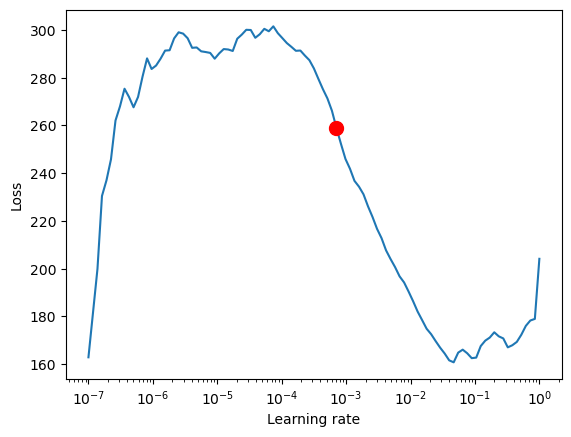

In [34]:
lr_finder = trainer.tune(model, datamodule=uc5_datamodule, lr_find_kwargs={"min_lr": 1e-7, "max_lr": 1,})

fig=lr_finder['lr_find'].plot(suggest=True)
fig.show()
lr_finder['lr_find'].suggestion()

# Evaluate the Model

In [20]:
from glob import glob

run = wandb.init()
artifact = run.use_artifact('hughes-lloyd/RepreSent_UC5/model-2p43le8n:v0', type='model')
artifact_dir = artifact.download()

checkpoint = os.path.join(artifact_dir, "model.ckpt")
# idx = -5
# checkpoints = glob(f"checkpoints/UC5ResNet/*/*.ckpt")
# checkpoint = checkpoints[idx]
print("Using checkpoint ", checkpoint)
# checkpoint = "represent/represent/weights/uc5_moco_resnet18_4px.pth"

args.patch_size_px = 12
args.s2_only = True

args.s2_level = 'L1C'
args.input_ch = [2, 13] if args.s2_level == 'L1C' else [2, 12]

if args.s2_only:
    args.input_ch = [13,]
    args.classification_head = torch.nn.Linear(512, 1)
else:
    args.classification_head = torch.nn.Linear(1024, 1)

s2_bands = None if args.s2_level == 'L1C' else [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12]

model = UC5ResNet(**args.__dict__)

model.load_state_dict(torch.load(checkpoint)['state_dict'], strict=False)
# model.load_from_checkpoint(checkpoint)
# model.classifier.load_state_dict(torch.load(checkpoint)['state_dict'], strict=False)
# model.load_from_checkpoint(checkpoint, filter_and_remap="streams.0.", stream_id=0)
# model.load_from_checkpoint(checkpoint, filter_and_remap="streams.1.", stream_id=1, input_ch_subset=s2_bands)

model = model.to('cuda')
model = model.eval()

wandb: Downloading large artifact model-2p43le8n:v0, 131.41MB. 1 files... Done. 0:0:0.0


Using checkpoint  ./artifacts/model-2p43le8n:v0/model.ckpt


In [21]:
from tqdm.notebook import tqdm

s1_norm = lambda x: 20*np.log10(x/535)

datamodule = UC5ForestBiomassDataModule.from_argparse_args(args, s1_transform=s1_norm)

datamodule.setup(stage=None)

def run_inference(model, dataloader):
    preds = []
    targets = []

    with torch.no_grad():
        for batch in tqdm(dataloader):
            xs, y_true = batch

            y_true = y_true.to('cuda')
            for i in range(len(xs)):
                xs[i] = xs[i].to('cuda')

            y_pred = model(xs)

            preds.append(y_pred.detach().cpu().numpy())
            targets.append(y_true.detach().cpu().numpy())
            
    preds = np.concatenate(preds)[:,0]
    targets = np.concatenate(targets)[:,0]

    return preds, targets

preds2, targets2 = run_inference(model, datamodule.train_dataloader())
predst, targetst = run_inference(model, datamodule.test_dataloader())


  0%|          | 0/22 [00:00<?, ?it/s]

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


  0%|          | 0/27 [00:00<?, ?it/s]

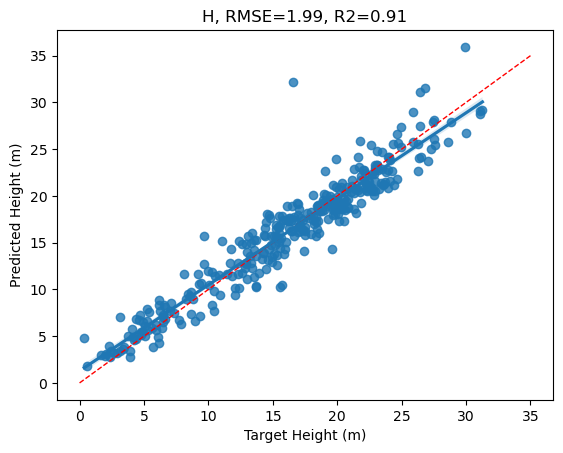

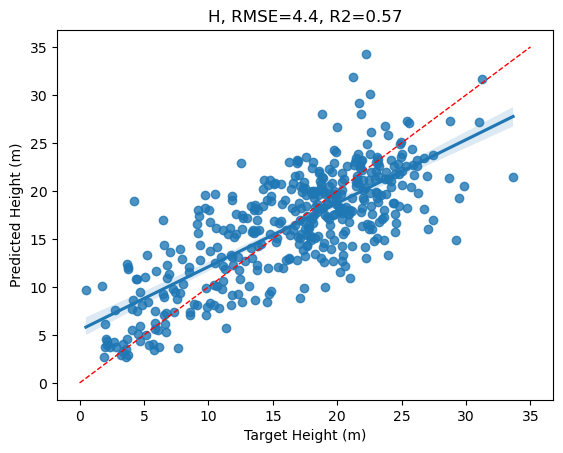

In [22]:
plot_regression(targets2, preds2)
plot_regression(targetst, predst)

# Recreate Baseline

In [219]:
import pandas as pd

args.patch_size_px = 2
args.batch_size = 1
args.s2_level = 'S2A'
args.training_set_fraction = 0.5

datamodule = UC5ForestBiomassDataModule.from_argparse_args(args,)
datamodule.setup(stage=None)

train = []

def df_from_dataloader(dataloader):
    records = []
    for batch in tqdm(dataloader):
        xs, y_true = batch

        s1 = xs[0].mean(axis=[0,2,3]).numpy()
        s2 = xs[1].mean(axis=[0,2,3]).numpy()

        data = {
            'S1-VV': s1[0],
            'S1-VH': s1[1],
        }

        for i in range(len(s2)):
            if i == 8:
                j = '8A'
            elif i >= 10:
                j = i + 1
            elif i > 8:
                j = i
            else:
                j = i + 1

            data[f"S2-{j}"] = s2[i]
            
            data['H'] = y_true[0,0].numpy()
        
        records.append(data)
    
    return pd.DataFrame.from_records(records)


df = df_from_dataloader(datamodule.train_dataloader())
df.to_csv("resplit_train.csv", index=False)

df2 = df_from_dataloader(datamodule.val_dataloader())
df = df_from_dataloader(datamodule.test_dataloader())
df = pd.concat([df, df2])
df.to_csv("resplit_test.csv", index=False)

  0%|          | 0/340 [00:00<?, ?it/s]

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/426 [00:00<?, ?it/s]

In [223]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

In [224]:
df_train = pd.read_csv("/home/lloyd/Documents/Experiments/RepreSent/resplit_train2.csv")
df_test = pd.read_csv("/home/lloyd/Documents/Experiments/RepreSent/resplit_test2.csv")

param_grid = {
    "n_neighbors": 7,
    "weights": 'distance',
    "algorithm": 'auto',
    "leaf_size": 30,
    "p": 1,
    "metric": 'minkowski'
}

neigh = KNeighborsRegressor(**param_grid)

# fts = ['idrow', 'idcol']
fts = ['S2-2', 'S2-3', 'S2-4', 'S2-5', 'S2-8', 'S2-11', 'S2-12', 'S1-VH', 'S1-VV']
# fts = ['S2-5', 'S2-8', 'S1-VH', 'S1-VV']

# idx = np.random.choice(np.arange(len(df_train)), 300)
X = df_train.loc[:, fts]
y = df_train.loc[:, ['H']]

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

X_test = df_test.loc[:, fts]
y_hat = df_test.loc[:, ['H']]
X_test = scaler.transform(X_test)

neigh.fit(X, y)

y_pred_train = neigh.predict(X)
y_pred = neigh.predict(X_test)

len(X), len(X_test)

(340, 512)

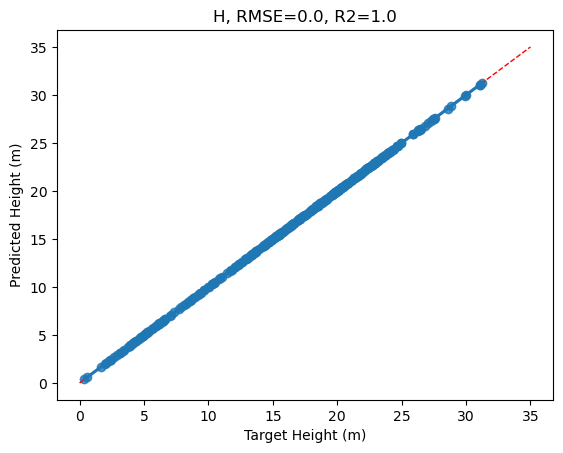

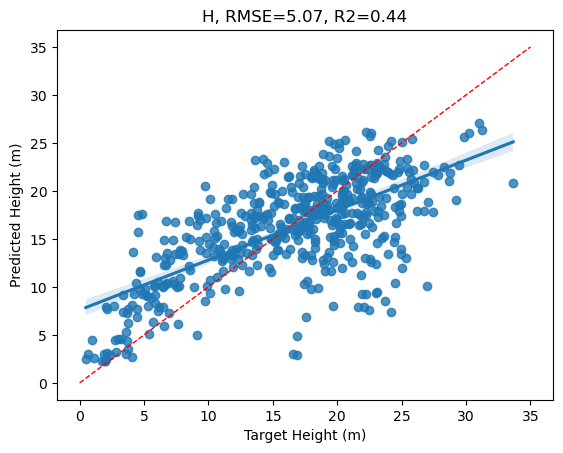

In [225]:
plot_regression(y, y_pred_train)
plot_regression(y_hat, y_pred)


# Export Dataset Splits

In [ ]:
datamodule = UC5ForestBiomassDataModule.from_argparse_args(args,)

datamodule.setup(stage=None)

train_idxs = datamodule.train_dataset.indices
val_idxs = datamodule.val_dataset.indices
test_idxs = datamodule.test_dataset.indices

df = datamodule.dataset.plots.drop(columns=["index", "geometry"])
df = df.set_geometry("patch")
df["set"] = "none"
df.loc[train_idxs, "set"] = "train"
df.loc[val_idxs, "set"] = "val"
df.loc[test_idxs, "set"] = "test"
df.to_file("uc5_dataset_raw.geojson", driver="GeoJSON")
# df.geometry

# Whole Scene Inference

In [70]:
args.s2_level = 'L1C'
datamodule = UC5ForestBiomassDataModule.from_argparse_args(args,)
datamodule.setup(stage=None)

s1_vv = datamodule.dataset.src_vv.read()
s1_vh = datamodule.dataset.src_vh.read()

s1_vv = np.mean(s1_vv, axis=0)
s1_vh = np.mean(s1_vh, axis=0)

s1_img = np.stack([s1_vv, s1_vh], axis=0)
s1_img = 20 * np.log10(s1_img / 535)
s2_img = datamodule.dataset.src_s2.read()

print(s1_img.shape, s2_img.shape)

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(2, 5000, 5000) (13, 5000, 5000)


In [71]:
def patchify(img, patch_shape):
    img = np.ascontiguousarray(img)  # won't make a copy if not needed
    ch, X, Y = img.shape
    _, x, y = patch_shape
    shape = ((X-x+1), (Y-y+1), ch, x, y) # number of patches, patch_shape
    # The right strides can be thought by:
    # 1) Thinking of `img` as a chunk of memory in C order
    # 2) Asking how many items through that chunk of memory are needed when indices
    #    i,j,k,l are incremented by one
    strides = img.itemsize*np.array([1, Y, Y*X, Y, 1])
    return np.lib.stride_tricks.as_strided(img, shape=shape, strides=strides)


In [141]:
patch_sz = 12
patches_s1 = patchify(s1_img, (2, patch_sz, patch_sz))
patches_s2 = patchify(s2_img, (13, patch_sz, patch_sz))

row, col, ch, y, x = patches_s1.shape

batch_sz = 1024

map_biomass = np.zeros((row, col))

with torch.no_grad():
    for r in tqdm(range(row)):
        for c in range(0, col, batch_sz):
            c_end = min(col, c + batch_sz)

            s1_batch = patches_s1[r, c:c_end]
            s2_batch = patches_s2[r, c:c_end]

            s1p = torch.from_numpy(s1_batch).to("cuda")
            s2p = torch.from_numpy(s2_batch).to("cuda")

            y_pred = model((s1p, s2p)).cpu().numpy().reshape(-1)
            
            map_biomass[c:c_end, r] = y_pred
            

  0%|          | 0/4989 [00:00<?, ?it/s]

In [258]:
map_biomass.max(), map_biomass.mean(), np.median(map_biomass)

# plt.figure()
# plt.imshow(map_biomass.T[2000:2500,2000:2500])

(99.01454162597656, 19.67477260739731, 15.842500686645508)

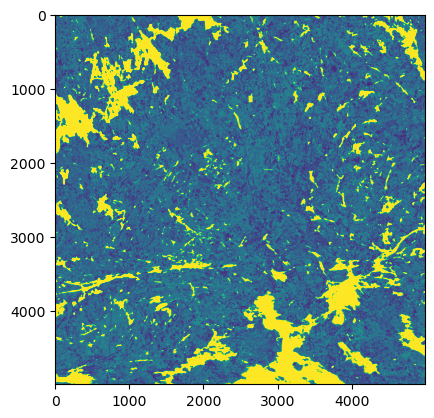

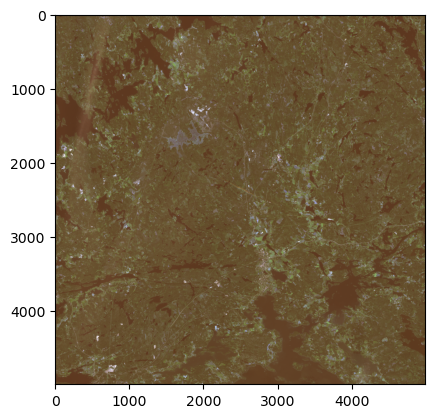

In [134]:
plt.figure()
plt.imshow(map_biomass.T)
plt.figure()
i = s2_img[1:4,6:-6,6:-6].transpose(1,2,0).clip(0, 0.2)
i = (i-i.min())/(i.ptp())
# print(i.min())
plt.imshow(i)


In [281]:
import rasterio 

def save_geotiff(result, src):
    tmp = np.zeros((5000, 5000))
    tmp[5:4989+5, 5:4989+5] = result
    
    meta = src.meta.copy()
    
    meta['count'] = 1
    
    with rasterio.open("result_uc5.tif", 'w', **meta) as dest:
        dest.write(tmp, 1)

save_geotiff(map_biomass, datamodule.dataset.src_s2)

# Data Exploration

In [ ]:
%%time

import rasterio 
import geopandas as gpd
import rioxarray as xr
from scipy.ndimage import uniform_filter, variance
from geocube.api.core import make_geocube

def lee_filter(img, size):
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output

df = gpd.read_file("/data/lloyd/RepreSent/UC5/GT/plot_shapefiles/forest_plots.shp")
# df["geometry"] = df["geometry"].centroid.buffer(100)

src_vh = xr.open_rasterio("/data/lloyd/RepreSent/UC5/S1/recH50km_VH_2015_10m.tif", chunks="auto")
src_vh = 10*np.log10(src_vh/65536)
# src = src.rio.clip(df.geometry.values, df.crs, from_disk=True)

src_vv = xr.open_rasterio("/data/lloyd/RepreSent/UC5/S1/recH50km_VV_2015_10m.tif", chunks="auto")
src_vv = 10*np.log10(src_vv/65536)
# src_vv = src_vv.rio.clip(df.geometry.values, df.crs, from_disk=True)

src_s2 = xr.open_rasterio("/data/lloyd/RepreSent/UC5/S2/S2A_MSIL2A_20150817_10m.tif", chunks="auto")


# out_grid= make_geocube(vector_data=df, measurements=["PLOTID"], like=src_vh)
# out_grid["VH"] = (src_vh.dims, src_vh.values, src_vh.attrs, src_vh.encoding)
# out_grid["VV"] = (src_vv.dims, src_vv.values, src_vv.attrs, src_vv.encoding)
# out_grid = out_grid.drop("spatial_ref")

In [ ]:
src = src_vv.rio.clip([box(*r[1]['geometry'].centroid.buffer(5).bounds)], df.crs, from_disk=True)
src

In [ ]:
%%time

grouped_VH = out_grid.groupby(out_grid.PLOTID)
grid_mean = grouped_VH.mean().rename({"VH": "VH_mean", "VV": "VV_mean"})
grid_mean.to_dataframe()

df_merged = gpd.GeoDataFrame(pd.merge(grid_mean.to_dataframe().reset_index(), df, on=["PLOTID","PLOTID"]))
df_merged.to_file("/data/lloyd/RepreSent/UC5/preprocessed_10m_mean.geojson", driver="GeoJSON")

In [ ]:
import matplotlib.pyplot as plt

df_merged = gpd.GeoDataFrame.from_file("/data/lloyd/RepreSent/UC5/preprocessed_10m_mean.geojson", driver="GeoJSON")

m = df_merged.groupby("PLOTID").agg({'VV_mean': 'mean', 'VH_mean': 'median', 'H': 'mean', 'V': 'mean'})
m['C'] = m.H//10
# plt.figure()
# _=plt.hist(m.H, bins=50)

# plt.figure()
# _=plt.hist(m.VV_mean, bins=50)

# plt.figure()
# plt.imshow(np.nan_to_num(out_grid.PLOTID.data,0))

plt.figure()
_=plt.scatter(m.VH_mean, m.H, c=m.C)
